#### Risk-Return Measures

In [2]:
import datetime as dt
import pandas as pd
import numpy as np

from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

import yfinance as yfin
yfin.pdr_override()




In [5]:
#Setting some arbitrary time period

end = dt.datetime.now()
start =end - dt.timedelta(days=1500)

In [3]:
# Stock list
stockList = ['FLT', 'HLO', 'QAN', 'VAS', 'WEB']
stocks = [stock+'.AX' for stock in stockList] #Yahoo finance requires .AX for ASX
print(stocks)

['FLT.AX', 'HLO.AX', 'QAN.AX', 'VAS.AX', 'WEB.AX']


In [33]:
# Getting the data
df = pdr.get_data_yahoo(stocks, start=start, end=end)




[*********************100%%**********************]  5 of 5 completed


In [7]:
# Compute Log returns
lnReturns = np.log(df.Close/df.Close.shift(1)).dropna()

In [8]:
# Standard Deviation and Annualizing
# Usually there is approximately 252 trading days in a year
daySD = lnReturns.std()

yearSD = daySD * np.sqrt(252)


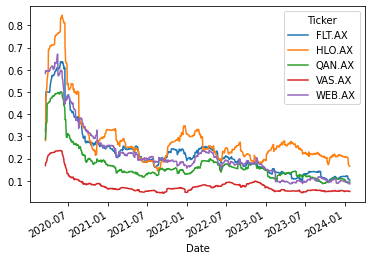

In [11]:
# Trailing Volatility
# useful for showing how volatilities change over time

DAYS=60
vol =lnReturns.rolling(window=DAYS).std()*np.sqrt(DAYS)
vol.plot()

### Sharpe Ratio

The Sharpe ratio seeks to characterize how well the return of an asset compensates the investor for the risk taken. 
 $$S_{a}=\frac{E[R_a - R_r]}{\sigma_{a}}=\frac{E[R_a - R_r]}{\sqrt{Var(R_a - R_r)}}$$
It represents the additional amount of return that an investor receives per unit of increase in risk

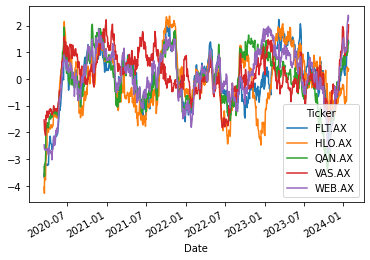

In [37]:
# define risk free rate at 
# currently, since our data goes back to 2020, and only has recently 
#  seen an increase in interest rates, we will use ~ yield of 1%
#
DAYS = 60
Rf = 0.01/252

# Rolling Sharpe Ratio to show how the sharpe ratio changed throughout time
sr = (lnReturns.rolling(window=DAYS).mean()-Rf)*DAYS/vol
sr.plot()

### Sortino Ratio
It is a modification of the Sharpe ratio but penalizes only those returns falling below a user-specified target or required rate of return
$$s=\frac{R-T}{DR}$$
Where $R$ is the asset or portfolio average realized return, $T$ is the target or required rate of return, and $DR$ is the target semi-deviation, termed downside deviation. DR was also known as minimum acceptable return MAR.

Under the way DR is defined, we can have different Sortino Ratio's for the same set of returns by adjusting what the minimum acceptable return is.




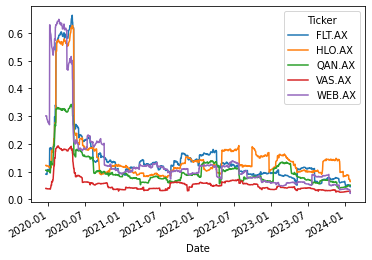

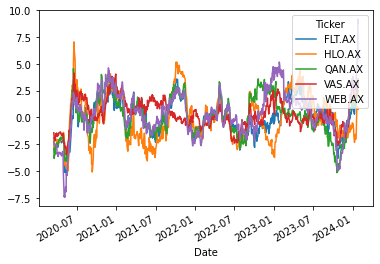

In [38]:
# Here, we are defining that minimum return is Log returns greater than
#  or equal to 0. 

# This means we only include log returns less than zero when calculating the
#  variance
DAYS = 60
Rf = 0.01/252


sorvol = lnReturns[lnReturns<0].rolling(window=DAYS, center=True, min_periods=10).std()*np.sqrt(DAYS)
sor = (lnReturns.rolling(window=DAYS).mean() - Rf)*DAYS / sorvol

sorvol.plot()
plt.show()

sor.plot()
plt.show()


### Modigliani ratio

Let $D_t$ be the excess return of the portfolio for some time period $t$.

Then we can define the sharpe ratio as 
$$S=\frac{\bar{\hat D}}{\sigma_D}$$
Where $\bar{\hat D}$ is the average of all excess returns over some period, and $\sigma_D$ is the standard deviation of those excess returns.

Then the ratio is defined by
$$M^2 := S*\sigma_B + \bar{\hat R}_F$$
Where $\sigma_B $ is the standard deviation of the excess returns for some benchmark portfolio against which you are comparing the portfolio in question, and $\bar{\hat R}_F$ is the average risk free rate for the period.

[*********************100%%**********************]  1 of 1 completed


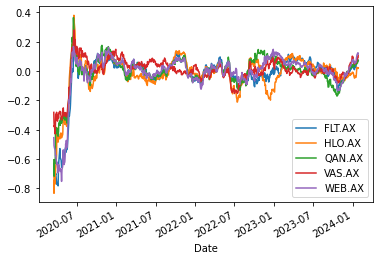

In [24]:
mr = pd.DataFrame()

dfb = pdr.get_data_yahoo('^AXJO', start=start, end=end)
# Compute Log returns
lnReturnsb = np.log(dfb.Close/df.Close.shift(1)).dropna()


DAYS = 60
bvol = lnReturnsb.rolling(window=DAYS).std()*np.sqrt(DAYS)

for c in lnReturns.columns:
    if c != '^AXJO':
        
        mr[c] = (sr[c]*bvol/DAYS + Rf)*DAYS

mr.plot()



#### Max Draw-Down
The draw-down is the measure of the decline from a historical peak. Useful for many reasons such as not relying on assuming underlying returns being normally distributed.

The maximum draw-down (MDD) up to time  $T$ is the maximum of the draw-down over the history of the variable.

Draw-down is defined as, for $t\in (0,T)$
$$D(T)=max[max(R_{t}-R_{T}),0]$$
Then the Maximum drawn-down is
$$MDD(T)=max D(\tau)=max[max(R_{t}-R_{\tau})]$$
where $\tau \in (0,T)$ and the $max(R_{t}-R_{\tau})$ has $t\in (0,\tau)$

In [34]:
def max_drawdown(returns):
    cumulative_returns = (returns+1).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns/peak)-1
    return drawdown.min()


close = df['Adj Close']
returns = close.pct_change()
md = max_drawdown(returns)
md*100




Ticker
FLT.AX   -80.228387
HLO.AX   -85.842227
QAN.AX   -70.357438
VAS.AX   -35.752025
WEB.AX   -83.965217
dtype: float64